# **Regresión Logística con un enfoque de Redes Neuronales**


## **1 - Paquetes**
Primero, ejecutemos la celda inferior para importar los paquetes que necesitaremos durante esta actividad.

* [numpy](https://render.githubusercontent.com/view/www.numpy.org) es el paquete fundamental para el cómputo científico con Python.
* [h5py](http://www.h5py.org/) es un paquete que nos permite interactuar con un dataset almacenado en un archivo H5.
* [matplotlib](http://matplotlib.org/) es una famosa biblioteca para dibujar gráficas en Python.
* [PIL](http://www.pythonware.com/products/pil/) y [scipy](https://www.scipy.org/) son utilizados al final del ejercicio para probar el modelo con una imagen proporcionada por el usuario.

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
#from lr_utils import load_dataset

%matplotlib inline

Definimos la función que usaremos para cargar los datos:

In [ ]:
#import numpy as np
#import h5py

def load_dataset(ruta):
    train_dataset = h5py.File(ruta + '/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # dataset de entrenamiento
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # etiquetas del dataset de entrenamiento

    test_dataset = h5py.File(ruta + '/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # dataset de prueba
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # etiquetas del dataset de prueba

    classes = np.array(test_dataset["list_classes"][:]) # la lista de clases

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## **2 - Descripción del problema del ejercicio**

Se tiene un dataset ("data.h5") que contiene:


*   Un conjunto de entrenamiento de m_train imágenes etiquetadas como Gato (y=1) o No Gato (y=0)
*   Un conjunto de prueba de m_test imágenes etiquetadas como Gato o No Gato.
* Cada imagen tiene la forma (num_px, num_px, 3) donde 3 es por los tres canales de colores (RGB). Por lo tanto, cada imagen es cuadrada (altura y ancho iguales a num_px).

Deberás construir un algoritmo de reconocimiento de imágenes que clasifique correctamente una fotografía como Gato o No Gato.

Revisemos el dataset para familiarizarnos con él.



Activamos la carga de archivos desde Drive:

In [1]:
#Activamos la carga de los archivos desde Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Listamos el contenido de la carpeta actual
!ls

drive  sample_data


In [2]:
#Listamos el contenido de la carpeta donde almaceno los datasets
!ls "/content/drive/My Drive/Colab Notebooks/datasets"

anew.csv       dataset_sa.txt  irony_dataset.txt  test_catvnoncat.h5  train_catvnoncat.h5
bienestar.csv  iris.csv        kobidata.csv	  titanic.csv


In [ ]:
ruta = "/content/drive/My Drive/Colab Notebooks/datasets"

In [ ]:
# Cargando los datos (Gato/No Gato)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset(ruta)

Agregamos "_orig" al final de los datasets de imágenes (train y test) porque vamos a preprocesarlos (preparar, normalizar o limpiar los datos). Después del preprocesarlos, tendremos los datasets en train_set_x y test_set_x (las etiquetas train_set_y y test_set_y no necesitan ningun preprocesamiento).

Cada línea de train_set_x_orig y test_set_x_orig es un arreglo representando una imagen. Es posible visualizar un ejemplo de las imágenes ejecutando el código siguiente. Puedes cambiar el valor de `index` y ejecutar de nuevo la celda para ver otras imágenes.

In [ ]:
train_set_x_orig.shape

(209, 64, 64, 3)

In [ ]:
train_set_y.shape

(1, 209)

In [ ]:
print(train_set_y)

[[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
  0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1
  1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0
  1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1
  0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]]


In [ ]:
print(train_set_y[0][7])

1


In [ ]:
print(train_set_y[:,7])

[1]


y = [1], it's a 'cat' picture.


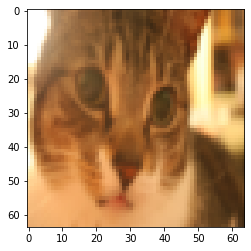

In [ ]:
# Ejemplo de una imagen
index = 200
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Muchos errores de los programas en aprendizaje profundo surgen de tener dimensiones de matrices/vectores que no coinciden. Si eres capaz de tener bajo control las dimensiones de tus matrices/vectores habrás avanzado muchísimo hacia la meta de eliminar una gran cantidad de errores.

**Ejercicio:** Encuentra los valores para:

  - m_train (número de ejemplos de entrenamiento)
  - m_test (número de ejemplos de prueba)
  - num_px (= altura = ancho de una imagen de entrenamiento)

Recuerda que `train_set_x_orig` es un arreglo-numpy de tamaño (m_train, num_px, num_px, 3). Por ejemplo, puedes determinar `m_train` escribiendo `train_set_x_orig.shape[0]`.

In [ ]:

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

print ("Número de ejemplos de entrenamiento: m_train = " + str(m_train))
print ("Número de ejemplos de prueba: m_test = " + str(m_test))
print ("Altura/Anchura de cada imagen: num_px = " + str(num_px))
print ("Tamaño de cada imagen.......: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("Forma (shape) de train_set_x: " + str(train_set_x_orig.shape))
print ("Forma (shape) de train_set_y: " + str(train_set_y.shape))
print ("Forma (shape) de test_set_x.: " + str(test_set_x_orig.shape))
print ("Forma (shape) de test_set_y.: " + str(test_set_y.shape))

Número de ejemplos de entrenamiento: m_train = 209
Número de ejemplos de prueba: m_test = 50
Altura/Anchura de cada imagen: num_px = 64
Tamaño de cada imagen.......: (64, 64, 3)
Forma (shape) de train_set_x: (209, 64, 64, 3)
Forma (shape) de train_set_y: (1, 209)
Forma (shape) de test_set_x.: (50, 64, 64, 3)
Forma (shape) de test_set_y.: (1, 50)


Por conveniencia, debemos cambiar la forma de las imagenes de (num_px, num_px, 3) a un arreglo-numpy de forma (num_px $*$ num_px $*$ 3, 1). Después de esto, nuestros datasets de training (y test) serán un arreglo-numpy donde cada columna representará a una imagen aplanada (flattened). Deberán ser m_train (respectivamente m_test) columnas en total.

**Ejercicio:** Reformatea los datasets training y test para que las imágenes de tamaño (num_px, num_px, 3) se aplanen en vectores sencillos de forma (num\_px $*$ num\_px $*$ 3, 1).

Un truco para cuando deseas aplanar una matriz X de forma (a,b,c,d) a una matriz X_flatten de forma (b$*$c$*$d, a) es utilizar:
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T es la transpuesta de X
```

In [ ]:
# Reformatea los ejemplos de entrenamiento y prueba

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("Forma de train_set_x_flatten: " + str(train_set_x_flatten.shape))
print ("Forma de train_set_y: " + str(train_set_y.shape))
print ("Forma de test_set_x_flatten: " + str(test_set_x_flatten.shape))
print ("Forma de test_set_y: " + str(test_set_y.shape))
print ("Verificación después del reformateo: " + str(train_set_x_flatten[0:5,0]))

Forma de train_set_x_flatten: (12288, 209)
Forma de train_set_y: (1, 209)
Forma de test_set_x_flatten: (12288, 50)
Forma de test_set_y: (1, 50)
Verificación después del reformateo: [17 31 56 22 33]


Para representar imágenes en color, los canales rojo, verde y azul (RGB) deben especificarse para cada píxel, por lo que el valor del pixel es en realidad un vector de tres números que van de 0 a 255.

Un paso de preprocesamiento común en el aprendizaje automático es centrar y estandarizar su conjunto de datos, lo que significa que debe restar la media de toda la matriz numpy de cada ejemplo y luego dividir cada ejemplo por la desviación estándar de toda la matriz numpy. Pero para los conjuntos de datos de imágenes, es más simple y conveniente y funciona casi tan bien, el simplemente dividir cada fila del conjunto de datos por 255 (el valor máximo de un canal de píxeles).

Estandaricemos nuestro conjunto de datos.

In [ ]:
train_set_x_flatten.shape

(12288, 209)

In [ ]:
print(train_set_x_flatten)

[[ 17 196  82 ... 143  22   8]
 [ 31 192  71 ... 155  24  28]
 [ 56 190  68 ... 165  23  53]
 ...
 [  0  82 138 ...  85   4   0]
 [  0  80 141 ... 107   5   0]
 [  0  81 142 ... 149   0   0]]


In [ ]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [ ]:
print(train_set_x)

[[0.06666667 0.76862745 0.32156863 ... 0.56078431 0.08627451 0.03137255]
 [0.12156863 0.75294118 0.27843137 ... 0.60784314 0.09411765 0.10980392]
 [0.21960784 0.74509804 0.26666667 ... 0.64705882 0.09019608 0.20784314]
 ...
 [0.         0.32156863 0.54117647 ... 0.33333333 0.01568627 0.        ]
 [0.         0.31372549 0.55294118 ... 0.41960784 0.01960784 0.        ]
 [0.         0.31764706 0.55686275 ... 0.58431373 0.         0.        ]]


**Lo que debes recordar:**

Los pasos comunes para pre-procesar un nuevo dataset son:
- Averiguar las dimensiones y formas del problema (m_train, m_test, num_px, ...)
- Reformatear los datasets de tal forma que cada ejemplo sea ahora un vector de tamaño (num_px \* num_px \* 3, 1)
- "Estandarizar" los datos

## **3 - Arquitectura general del algoritmo de aprendizaje**

Es hora de desarrollar un algoritmo que permita distinguir entre imágenes de gatos y no gatos.

Construiremos una Regresión Logística usando un enfoque en redes neuronales. La siguiente figura explica el porqué **¡La Regresión Logística es en realidad una muy sencilla red neuronal!**

<img src="https://miro.medium.com/max/1000/1*AQOZAD25B9jyDgzDqfjfWg.png" style="width:650px;height:400px;">

**Expresión matemática del algoritmo**:

Para un ejemplo $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Luego, el costo se calcula sumando todos los ejemplos de entrenamiento:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

**Pasos clave**:

En este ejercicio, realizará los siguientes pasos:

*   Inicializar los parámetros del modelo
*   Aprender los parámetros del modelo minimizando el costo
* Utilizar los parámetros aprendidos para hacer predicciones (en el conjunto de prueba)
* Analizar los resultados y establecer sus conclusiones



## **4 - Construyendo las partes del algoritmo**

Los pasos principales para construir una red neuronal son:
1. Definir la estructura del modelo (como el número de características de entrada)
2. Inicializar los parámetros del modelo
3. Ciclo:
    - Calcular la pérdida actual (loss) (propagación hacia adelante - forward propagation)
    - Calcular el gradiente actual (retropropagación - backward propagation)
    - Actualizar los parámetros (descenso del gradiente - gradient descent)

Normalmente hacemos los pasos 1 al 3 por separado y los integramos en una función llamada `model()`.

### **4.1 - Funciones auxiliares**

**Ejercicio**: Implementa la función `sigmoid()`. Como puedes observar en la figura de arriba, necesitas calcular $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ para hacer las predicciones. Usa np.exp().

In [ ]:

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1/(1+np.exp(-z))

    return s

In [ ]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Salida esperada**:

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td>
  </tr>
</table>

### **4.2 - Inicializando parámetros**

**Ejercicio:** Implemente la inicialización de parámetros en la celda de abajo. Debe inicializar w como un vector de ceros. La función de numpy que usaremos es np.zeros().

In [ ]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    w = np.zeros((dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

In [ ]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Salida esperada**:


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

Para entradas de imágenes, w será de la forma (num_px $\times$ num_px $\times$ 3, 1).

### **4.3 - Propagación hacia adelante y hacia atrás ( Forward and Backward propagation)**

Ahora que los parámetros están inicializados, podemos hacer los pasos de propagación "forward" y "backward" para aprender (ajustar) los parámetros.

**Ejercicio:** Implemente una función `propagate()` que calcule la función de costo y su gradiente.

Forward Propagation:
- Obtienes X
- Calculas $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculas la función de costo: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Aquí están las fórmulas:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

In [ ]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                     # calcula activación
    cost = -np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))/m  # calcula el costo


    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = np.dot(X,(A-Y).T)/m
    db = np.sum(A-Y)/m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [ ]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


**Salida esperada**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### **4.4 - Optimización**
- Has inicializado los parámetros.
- También eres capaza de calcular una función de costos y su gradiente.
- Ahora, quieres actualizar los parámetros utilizando el descenso del gradiente (gradient descent).

**Ejercicio:** Codifique la función de optimización. La meta es aprender $w$ y $b$ minimizando la función de costo $J$. Para un parámetro $\theta$, la regla de actualización es $ \theta = \theta - \alpha \text{ } d\theta$, donde $\alpha$ es la tasa de aprendizaje (learning rate).

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [ ]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


**La salida esperada**:

<table style="width:50%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.19033591]
 [ 0.12259159]] </td>
    </tr>
    <tr>
       <td> **b** </td>
       <td> 1.92535983008 </td>
    </tr>    
    <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042]
 [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>
</table>

**Ejercicio:** la función previa dará como salida los valores aprendidos de w y b. Podemos ahora usar los valores de w y b para predecir las etiquetas para un dataset X. Implementar la función `predict()`. Existen dos pasos para calcular predicciones:

1. Calcular $\hat{Y} = A = \sigma(w^T X + b)$

2. Convertir las entradas de a en 0 (if activation <= 0.5) o 1 (if activation > 0.5), almacenar la spredicciones en un vector `Y_prediction`.

In [ ]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X)+b)

    print(A.shape)
    for i in range(A.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]

        if A[0,i]<=0.5:
            Y_prediction[0,i]=0
        else:
            Y_prediction[0,i]=1
        pass


    assert(Y_prediction.shape == (1, m))

    return Y_prediction

In [ ]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

(1, 3)
predictions = [[1. 1. 0.]]


## **5 - Unir todas las funciones en un modelo**


In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    ### START CODE HERE ###

    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

### **5.1 Entrenar el modelo:**

In [ ]:
train_set_x.shape

(12288, 209)

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
(1, 50)
(1, 209)
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 1, you predicted that it is a "cat" picture.


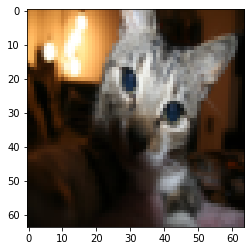

In [ ]:
# Ejemplo de clasificación.
index = 40
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

## **6 - Probemos el modelo con una imagen propia** ##

Puedes usar una imagen propia para probar el modelo. Para hacerlo:

1. Agrega la imagen a tu repositorio.
2. Cambia la ruta a la imagen.
3. Ejecuta el código y verifica si la predicción es correcta (1 = cat, 0 = non-cat).

In [ ]:
#fname = "./sample_data/gatito.jpg"
fname = "/content/drive/My Drive/Colab Notebooks/imagenes/gatito.jpg"
#fname = "/content/drive/My Drive/Colab Notebooks/imagenes/torre_eiffel.jpg"
image_orig = Image.open(fname)
image = image_orig.resize((num_px,num_px))
image = np.array(image)
image = image/255.
print(image.shape)

(64, 64, 3)


In [ ]:
my_image = image.reshape((1, num_px*num_px*3)).T
print(my_image.shape)

(12288, 1)


(1, 1)
y = 1.0, your algorithm predicts a "cat" picture.


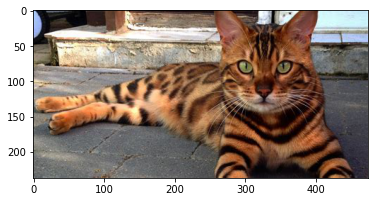

In [ ]:
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image_orig)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

## 7. **Usando una imagen desde Internet**

## Modo 1

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
%matplotlib inline


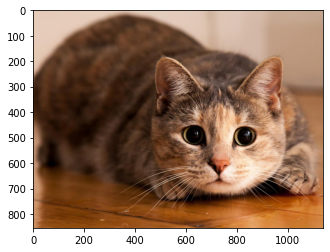

In [ ]:
url = "https://estaticos.muyinteresante.es/media/cache/1140x_thumb/uploads/images/gallery/59c4f5655bafe82c692a7052/gato-marron_0.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)